In [2]:
import matplotlib.pyplot as plt

import openmoc
import openmoc.plotter as plotter
import openmoc.process as process
from openmoc.materialize import load_from_hdf5

%matplotlib inline

/home/drsdl/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Simulation Runtime Parameters

In [3]:
num_threads = 4
azim_spacing = 0.05
num_azim = 16
tolerance = 1E-5
max_iters = 50

## Initialize Materials

In [4]:
materials = load_from_hdf5(filename='c5g7-mgxs.h5', directory='..')
print(materials.keys())

dict_keys(['Control Rod', 'Fission Chamber', 'Guide Tube', 'MOX-4.3%', 'MOX-7%', 'MOX-8.7%', 'UO2', 'Water'])


## Create Bounding Surfaces

In [5]:
# Create ZCylinder for the fuel
fuel_radius = openmoc.ZCylinder(x=0.0, y=0.0, radius=0.54)

In [6]:
# Create planes to bound the entire geometry
boundary = openmoc.RectangularPrism(21.42, 21.42)
boundary.setBoundaryType(openmoc.REFLECTIVE)

## Create Fuel Pins

In [7]:
# 4.0%  UOX pin cell
uox40_cell = openmoc.Cell()
uox40_cell.setFill(materials['UO2'])
uox40_cell.setNumRings(3)
uox40_cell.setNumSectors(8)
uox40_cell.addSurface(-1, fuel_radius)

uox40 = openmoc.Universe(name='UO2')
uox40.addCell(uox40_cell)

In [8]:
# Guide tube pin cell
guide_tube_cell = openmoc.Cell()
guide_tube_cell.setFill(materials['Guide Tube'])
guide_tube_cell.setNumRings(3)
guide_tube_cell.setNumSectors(8)
guide_tube_cell.addSurface(-1, fuel_radius)

guide_tube = openmoc.Universe(name='Guide Tube')
guide_tube.addCell(guide_tube_cell)

In [9]:
# Moderator rings
moderator = openmoc.Cell()
moderator.setFill(materials['Water'])
moderator.addSurface(+1, fuel_radius)
moderator.setNumRings(3)
moderator.setNumSectors(8)

In [10]:
# Add moderator rings to each pin cell
pins = [uox40, guide_tube]
for pin in pins:
    pin.addCell(moderator)

In [11]:
# CellFills for the assembly
assembly1_cell = openmoc.Cell(name='Fuel Assembly')

assembly1 = openmoc.Universe(name='Fuel Assembly')
assembly1.addCell(assembly1_cell)

## Create Fuel Assembly

In [12]:
# A mixed enrichment PWR MOX fuel assembly
assembly = openmoc.Lattice(name='UOX Assembly')
assembly.setWidth(width_x=1.26, width_y=1.26)

# Create a template to map to pin cell types
template = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 1],
            [1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 4, 1, 1, 4, 1, 1, 4, 1, 1, 4, 1, 1, 4, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 4, 1, 1, 4, 1, 1, 4, 1, 1, 4, 1, 1, 4, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1],
            [1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

universes = {1 : uox40, 
             4 : guide_tube}

for i in range(17):
    for j in range(17):
        template[i][j] = universes[template[i][j]]

assembly.setUniverses([template])

In [13]:
# Root Cell/Universe
root_cell = openmoc.Cell(name='Full Geometry')
root_cell.setFill(assembly)
root_cell.setRegion(boundary)

root_universe = openmoc.Universe(name='Root Universe')
root_universe.addCell(root_cell)

## Initialize CMFD

In [14]:
cmfd = openmoc.Cmfd()
cmfd.setSORRelaxationFactor(1.5)
cmfd.setLatticeStructure(17,17)
cmfd.setGroupStructure([[1,2,3], [4,5,6,7]])
cmfd.setKNearest(3)

## Initialize Geometry

In [15]:
geometry = openmoc.Geometry()
geometry.setRootUniverse(root_universe)
geometry.setCmfd(cmfd)

[  NORMAL ]  Plotting the materials...


/home/drsdl/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


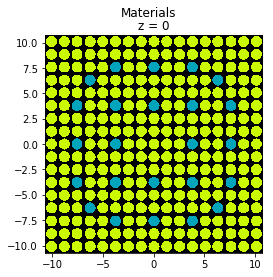

In [16]:
# Plot the geometry color-coded by materials
fig = plotter.plot_materials(geometry, gridsize=500, get_figure=True)
fig.set_figheight(4)
plt.show()

[  NORMAL ]  Plotting the cells...


/home/drsdl/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


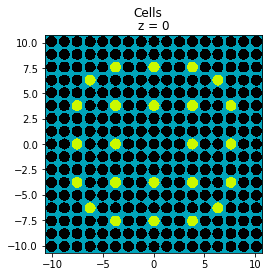

In [17]:
# Plot the geometry color-coded by cells
fig = plotter.plot_cells(geometry, gridsize=500, get_figure=True)
fig.set_figheight(4)
plt.show()

## Initialize TrackGenerator

In [18]:
track_generator = openmoc.TrackGenerator(geometry, num_azim, azim_spacing)
track_generator.setNumThreads(num_threads)
track_generator.generateTracks()

[  NORMAL ]  Importing ray tracing data from file...


In [19]:
# Plot the geometry color-coded by flat source region
##fig = plotter.plot_flat_source_regions(geometry, gridsize=500, get_figure=True)
##fig.set_figheight(4)
##plt.show()

# Plot the geometry color-coded by CMFD cells
##fig = plotter.plot_cmfd_cells(geometry, cmfd, gridsize=500, get_figure=True)
##fig.set_figheight(4)
##plt.show()

## Run Simulation

In [20]:
solver = openmoc.CPUSolver(track_generator)
solver.setConvergenceThreshold(tolerance)
solver.setNumThreads(num_threads)
solver.computeEigenvalue(max_iters)

[  NORMAL ]  Computing the eigenvalue...
[  NORMAL ]  Iteration 0:	k_eff = 1.406231	res = 0.000E+00
[  NORMAL ]  Iteration 1:	k_eff = 1.374864	res = 1.106E-01
[  NORMAL ]  Iteration 2:	k_eff = 1.359391	res = 4.192E-02
[  NORMAL ]  Iteration 3:	k_eff = 1.348757	res = 2.320E-02
[  NORMAL ]  Iteration 4:	k_eff = 1.341820	res = 1.616E-02
[  NORMAL ]  Iteration 5:	k_eff = 1.337607	res = 1.012E-02
[  NORMAL ]  Iteration 6:	k_eff = 1.335102	res = 6.267E-03
[  NORMAL ]  Iteration 7:	k_eff = 1.333685	res = 3.826E-03
[  NORMAL ]  Iteration 8:	k_eff = 1.332911	res = 2.277E-03
[  NORMAL ]  Iteration 9:	k_eff = 1.332512	res = 1.344E-03
[  NORMAL ]  Iteration 10:	k_eff = 1.332324	res = 8.013E-04
[  NORMAL ]  Iteration 11:	k_eff = 1.332245	res = 4.962E-04
[  NORMAL ]  Iteration 12:	k_eff = 1.332220	res = 3.250E-04
[  NORMAL ]  Iteration 13:	k_eff = 1.332220	res = 2.241E-04
[  NORMAL ]  Iteration 14:	k_eff = 1.332231	res = 1.588E-04
[  NORMAL ]  Iteration 15:	k_eff = 1.332244	res = 1.129E-04
[  NORMAL

[  NORMAL ]  Plotting the FSR scalar fluxes...


/home/drsdl/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


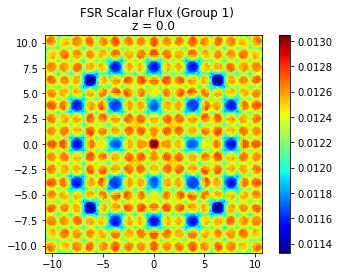

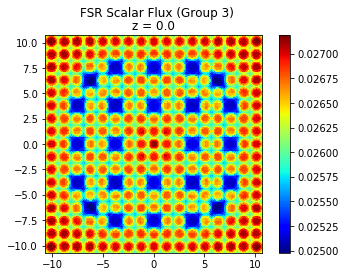

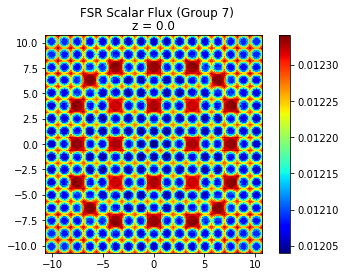

In [21]:
# Plot fast, epithermal and thermal flux
figures = plotter.plot_spatial_fluxes(solver, energy_groups=[1,3,7],
                                      gridsize=500, get_figure=True)
map(lambda fig: fig.set_figheight(4), figures)
plt.show()

[  NORMAL ]  Plotting the flat source region fission rates...


/home/drsdl/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


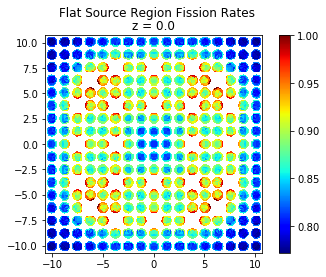

In [22]:
# Plots FSR fission rates
fig = plotter.plot_fission_rates(solver, gridsize=250,
                                 norm=True, get_figure=True)
fig.set_figheight(4)
plt.show()

In [23]:
#store solver results
process.store_simulation_state(solver, use_hdf5=True, filename="states-uo2-assembly-reference")

In [24]:
import numpy as np

# Retrieve the Materials and number of groups from the geometry
materials = geometry.getAllMaterials()
num_groups = geometry.getNumEnergyGroups()

# Create OpenMOC Mesh on which to tally fission rates
mesh = openmoc.process.Mesh()
mesh.dimension = [17*2, 17*2]
mesh.lower_left = [-21.42/2, -21.42/2]
mesh.upper_right= [ 21.42/2,  21.42/2]
mesh.width = [21.42/(17*2), 21.42/(17*2)]
#mesh.mesh_cell_volume = 21.42*21.42/(17*2*17*2) # not yet implemented


# Aggregate the total cross sections for each Material
# into a dictionary to pass to the mesh tally
domains_to_coeffs = {}
domains_to_coeffsPhi = {}

for material_id in materials:
    domains_to_coeffs[material_id] = np.zeros(num_groups)
    domains_to_coeffsPhi[material_id] = np.zeros(num_groups)
    for group in range(num_groups):
        domains_to_coeffs[material_id][group] = materials[material_id].getSigmaFByGroup(group+1)
        #domains_to_coeffs[material_id][group] = materials[material_id].getSigmaTByGroup(group+1)
        #domains_to_coeffs[material_id][group] = materials[material_id].getSigmaSByGroup(group+1,7)
        domains_to_coeffsPhi[material_id][group] = 1.0
        
# Tally volume-averaged OpenMOC total rates on the Mesh
#print(len(domains_to_coeffs))
#print(materials)
#print(domains_to_coeffs)
tot_rates = mesh.tally_on_mesh(solver, domains_to_coeffs, domain_type='material', volume='integrated')
Phi = mesh.tally_on_mesh(solver, domains_to_coeffsPhi, domain_type='material', energy='by_group', volume='integrated')

## check if 'tally_on_mesh' gives identical results as 'tally_fission_rates' 
#tot_rates = mesh.tally_fission_rates(solver)

1156


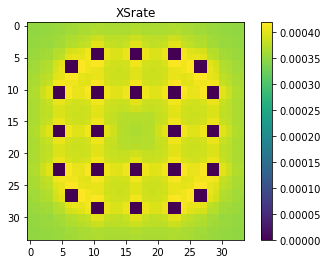

In [25]:
#https://stackoverflow.com/questions/32462881/add-colorbar-to-existing-axis
print(tot_rates.size)
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_title('XSrate')
ax.set_aspect('equal')
plt.imshow(tot_rates)

plt.colorbar(orientation='vertical')
plt.show()

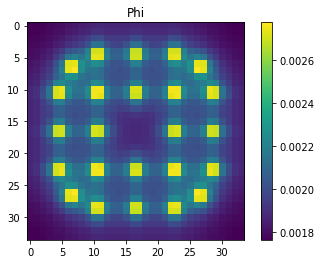

In [26]:
#fig = plotter.plot_flat_source_regions(geometry, gridsize=250,get_figure=True)
#fig.set_figheight(4)
#plt.show()

fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_title('Phi')
ax.set_aspect('equal')
#plt.imshow(Phi[:,:,1-1])  # fast flux group
plt.imshow(Phi[:,:,7-1])  # thermal flux group

plt.colorbar(orientation='vertical')
plt.show()


[  NORMAL ]  Plotting the FSR scalar fluxes...


/home/drsdl/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


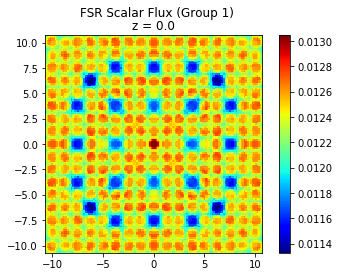

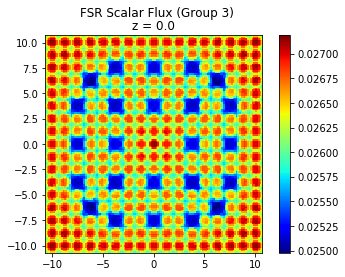

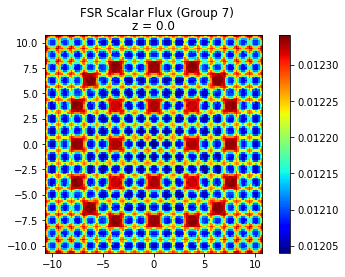

In [27]:
# for comparison plot thermal flux from native plotter tool
figures = plotter.plot_spatial_fluxes(solver, energy_groups=[1,3,7],
                                      gridsize=17*8, get_figure=True)
map(lambda fig: fig.set_figheight(4), figures)
plt.show()

[  NORMAL ]  Plotting the scalar fluxes vs. energy...


/home/drsdl/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


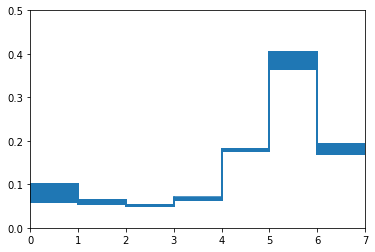

In [77]:
from copy import copy
from matplotlib.lines import Line2D

figures = plotter.plot_energy_fluxes(solver, fsrs=list(range(1,1000)), get_figure=True)
map(lambda fig: fig.set_figheight(1), figures)
graf = plt.figure()
ax = graf.add_subplot(111)

for fig in figures:
    hand=fig.gca()
    for l in hand.lines:
        #print(l.get_xdata(), l.get_ydata())
        #print(type(l.get_xdata()), type(l.get_ydata()))
        new_l=Line2D(l.get_xdata(), l.get_ydata())
        ax.add_line(new_l)
    plt.close(fig)

axi = graf.gca()
axi.set_xlim([0.0,7.0])
axi.set_ylim([0.0,0.5])


plt.show()

In [177]:
# Create OpenMOC Mesh on which to tally fission rates
meshU = openmoc.process.Mesh()
meshU.dimension = [1, 1]
meshU.lower_left = [-21.42/2, -21.42/2]
meshU.upper_right= [ 21.42/2,  21.42/2]
meshU.width = [21.42, 21.42]

# Aggregate the total cross sections for each Material
# into a dictionary to pass to the mesh tally
domains_to_coeffsF = {}
domains_to_coeffsT = {}
domains_to_coeffsSx7 = {}
domains_to_coeffsPhi = {}

for material_id in materials:
    domains_to_coeffsF[material_id] = np.zeros(num_groups)
    domains_to_coeffsT[material_id] = np.zeros(num_groups)
    domains_to_coeffsSx7[material_id] = np.zeros(num_groups)
    domains_to_coeffsPhi[material_id] = np.zeros(num_groups)
    for group in range(num_groups):
        domains_to_coeffsF[material_id][group] = materials[material_id].getSigmaFByGroup(group+1)
        domains_to_coeffsT[material_id][group] = materials[material_id].getSigmaTByGroup(group+1)
        domains_to_coeffsSx7[material_id][group] = materials[material_id].getSigmaSByGroup(group+1,7)
        domains_to_coeffsPhi[material_id][group] = 1.0 # gives the flux
        
F_rates   = meshU.tally_on_mesh(solver, domains_to_coeffsF,   domain_type='material', energy='by_group', volume='integrated')
T_rates   = meshU.tally_on_mesh(solver, domains_to_coeffsT,   domain_type='material', energy='by_group', volume='integrated')
Sx7_rates = meshU.tally_on_mesh(solver, domains_to_coeffsSx7, domain_type='material', energy='by_group', volume='integrated')
Phi       = meshU.tally_on_mesh(solver, domains_to_coeffsPhi, domain_type='material', energy='by_group', volume='integrated')


In [180]:
# check normalization of results for different mesh sizes
ref_volume=17*17*2*2
print(F_rates.shape)
print(F_rates/(ref_volume))
print(np.sum(F_rates)/(ref_volume))
print(np.sum(T_rates)/(ref_volume))
print(np.sum(Sx7_rates)/(ref_volume))
print(Phi/(ref_volume))

(1, 1, 7)
[[[  1.90053703e-05   4.58517903e-06   1.64127547e-05   1.71445397e-05
     1.27433326e-05   6.84137581e-05   2.14337067e-04]]]
0.00035264200151
0.0132169120235
0.00320030352896
[[[ 0.00490991  0.010437    0.00483558  0.0017873   0.00136439  0.00160764
    0.00206204]]]
